In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
# 加载数据
datafilename1 = "C:\\Users\\Administrator\\Desktop\\MFEG\\dataprocessing\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']



In [4]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dropout, Dense,MaxPool1D
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size, strides):
    shortcut = x
    # 主卷积路径
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # 如果shortcut的形状与x不匹配，则调整shortcut
    if shortcut.shape[-1] != x.shape[-1] or shortcut.shape[-2] != x.shape[-2]:
        shortcut = Conv1D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # 添加跳过连接
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 19, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = residual_block(x, 32, 3, 2)
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 128, 3, 2)
    x1 = GRU(128, return_sequences=False)(x)
    x2 = GRU(128, return_sequences=False)(x)
    x=x1+x2
    x = Dropout(0.1)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Example usage:
model =resnet((4500, 1), 4)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4500, 32)     640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4500, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 4500, 32)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=256, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
55/55 [==============================] - 30s 266ms/step - loss: 0.4226 - accuracy: 0.5798 - val_loss: 0.4446 - val_accuracy: 0.5766
Epoch 2/80
55/55 [==============================] - 12s 221ms/step - loss: 0.4058 - accuracy: 0.5907 - val_loss: 0.4141 - val_accuracy: 0.5733
Epoch 3/80
55/55 [==============================] - 12s 224ms/step - loss: 0.3996 - accuracy: 0.5994 - val_loss: 0.4013 - val_accuracy: 0.5907
Epoch 4/80
55/55 [==============================] - 12s 226ms/step - loss: 0.3758 - accuracy: 0.6352 - val_loss: 0.3830 - val_accuracy: 0.6332
Epoch 5/80
55/55 [==============================] - 12s 220ms/step - loss: 0.3441 - accuracy: 0.6742 - val_loss: 0.3401 - val_accuracy: 0.6714
Epoch 6/80
55/55 [==============================] - 12s 226ms/step - loss: 0.3163 - accuracy: 0.7055 - val_loss: 0.3292 - val_accuracy: 0.7063
Epoch 7/80
55/55 [==============================] - 13s 228ms/step - loss: 0.2924 - accuracy: 0.7429 - val_loss: 0.3209 - val_accuracy: 0.6839

In [7]:
evaluate_model(model,X_test,y_test)

Precision: 0.8480363671270807
Recall: 0.7176961974134647
F1 Score: 0.7541757342527389
Accuracy: 0.8600160901045857
Class 1 - Precision: 0.826271186440678, Recall: 0.8590308370044053, F1 Score: 0.8423326133909288
Class 2 - Precision: 0.8908742820676452, Recall: 0.9300466355762825, F1 Score: 0.9100391134289441
Class 3 - Precision: 0.8, Recall: 0.7317073170731707, F1 Score: 0.7643312101910827
Class 4 - Precision: 0.875, Recall: 0.35, F1 Score: 0.4999999999999999
Class 1 Accuracy: 0.9706355591311343
Class 2 Accuracy: 0.8889782783588094
Class 3 Accuracy: 0.8660498793242156
Class 4 Accuracy: 0.9943684633950121


In [8]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

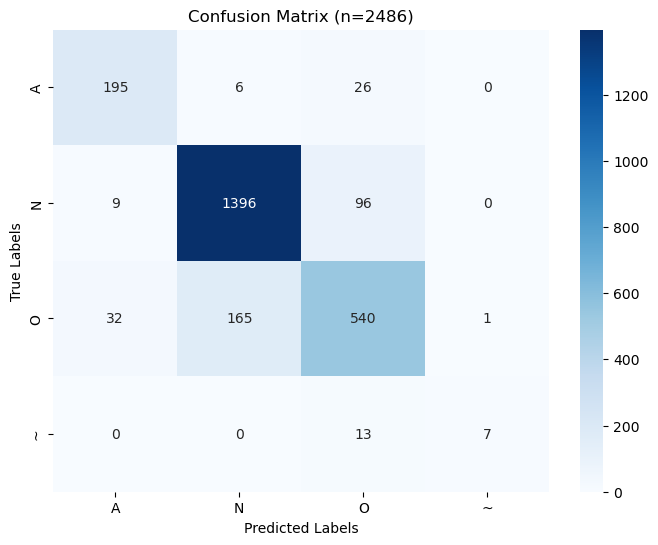

In [9]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])